In [50]:
# Import the required libraries
import pandas as pd           
import numpy as np            
import matplotlib.pyplot as plt  
from statsmodels.tsa.seasonal import seasonal_decompose  
from statsmodels.tsa.stattools import adfuller           
from statsmodels.graphics.tsaplots import plot_acf   

In [59]:
df = pd.read_csv('cleaned_chocolate_data.csv')
path = ...\6.1'

In [60]:
print("First five rows of the dataset:")
print(df.head())

First five rows of the dataset:
    company specific_origin   ref  review_date cocoa_percent location  rating  \
0  A. Morin     Agua Grande  1876         2016           63%   France    3.75   
1  A. Morin           Kpime  1676         2015           70%   France    2.75   
2  A. Morin          Atsane  1676         2015           70%   France    3.00   
3  A. Morin           Akata  1680         2015           70%   France    3.50   
4  A. Morin          Quilla  1704         2015           70%   France    3.50   

  bean_type bean_origin  
0              Sao Tome  
1                  Togo  
2                  Togo  
3                  Togo  
4                  Peru  


In [61]:
# Convert the 'review_date' column to datetime format.
# We assume January 1st of that year for conversion.
df['review_date'] = pd.to_datetime(df['review_date'], format='%Y')

In [62]:
# Step 3
# Create a subset with only dates from 2010 and later:
df_subset = df[df['review_date'].dt.year >= 2010].copy()
df_subset.reset_index(drop=True, inplace=True)
df_subset.set_index('review_date', inplace=True)
print("Subsetted Data (from 2010 onward):")
print(df_subset.head())

Subsetted Data (from 2010 onward):
              company specific_origin   ref cocoa_percent location  rating  \
review_date                                                                  
2016-01-01   A. Morin     Agua Grande  1876           63%   France    3.75   
2015-01-01   A. Morin           Kpime  1676           70%   France    2.75   
2015-01-01   A. Morin          Atsane  1676           70%   France    3.00   
2015-01-01   A. Morin           Akata  1680           70%   France    3.50   
2015-01-01   A. Morin          Quilla  1704           70%   France    3.50   

            bean_type bean_origin  
review_date                        
2016-01-01               Sao Tome  
2015-01-01                   Togo  
2015-01-01                   Togo  
2015-01-01                   Togo  
2015-01-01                   Peru  


#### Subsetting Logic:
##### I have chosen to subset the dataset to include only records from 2010 onward. This decision is based on the idea that older data or any  
##### forecasted data might bias the analysis. After subsetting, I reset the index and then set the review_date column as the DataFrame’s index, which
##### is essential for time series operations.

Time Series (Average Rating per Year):
review_date
2010-01-01    3.148649
2011-01-01    3.256061
2012-01-01    3.178205
2013-01-01    3.197011
2014-01-01    3.189271
2015-01-01    3.246491
2016-01-01    3.226027
2017-01-01    3.312500
Freq: YS-JAN, Name: rating, dtype: float64


...\ipykernel_23044\3289481522.py:7: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  ts = ts.asfreq('AS')


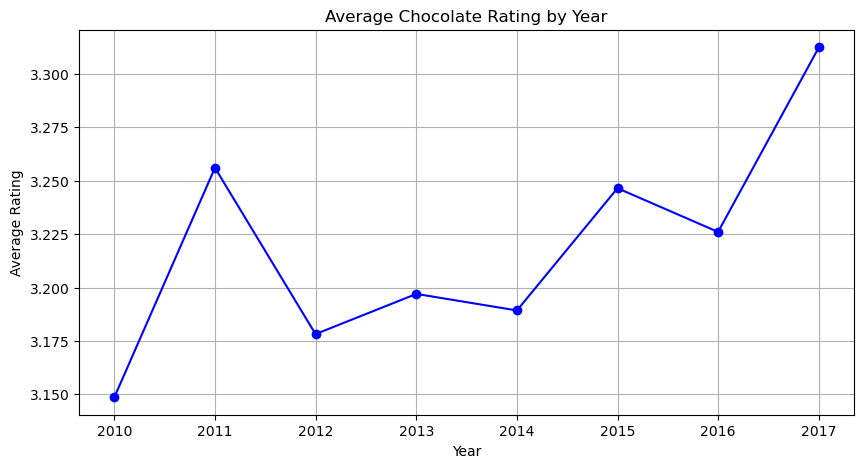

In [63]:
#Step 4
# Group then we calculate the mean
ts = df_subset.groupby(df_subset.index)['rating'].mean().sort_index()

# Since the review dates are yearly, we can set an annual frequency.
# 'AS' stands for "annual start".
ts = ts.asfreq('AS')
print("Time Series (Average Rating per Year):")
print(ts)

# Plot the time series.
plt.figure(figsize=(10, 5))
plt.plot(ts.index, ts.values, marker='o', linestyle='-', color='b')
plt.title('Average Chocolate Rating by Year')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.grid(True)
plt.show()

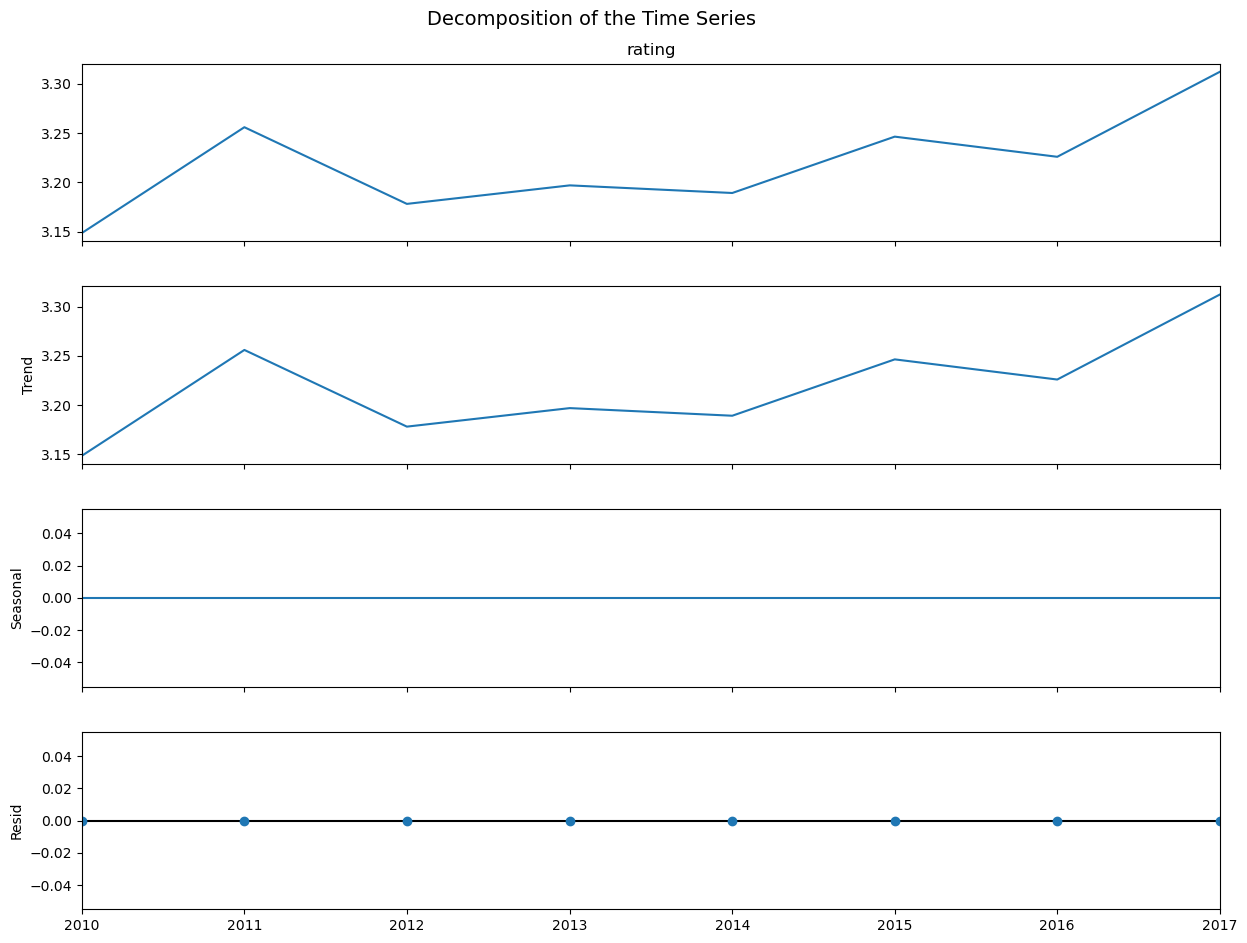

In [64]:
# Step 5
# Decompose the data's components
decomposition = seasonal_decompose(ts, model='additive', period=1)

# Plot the decomposed components.
fig = decomposition.plot()
fig.set_size_inches(14, 10)
plt.suptitle('Decomposition of the Time Series', fontsize=14)
plt.show()

### **Analysis of the Decomposition Plot**:
- Trend: Shows the long-term movement in average ratings over the years.  
- Seasonal: Since our data are annual, a seasonal effect is not expected (thus period=1).  
- Residual: Displays the noise or irregular fluctuations after removing trend (and seasonality).  
 This decomposition helps in understanding how much variation in ratings is due to the overall trend versus random noise.  

In [65]:
# Step 6
# Conduct a Dickey-Fuller test to check for stationarity.
adf_result = adfuller(ts.dropna())
print("Dickey-Fuller Test on Original Series:")
print("ADF Statistic: {:.4f}".format(adf_result[0]))
print("p-value: {:.4f}".format(adf_result[1]))
print("Critical Values:")
for key, value in adf_result[4].items():
    print("  {}: {:.4f}".format(key, value))

Dickey-Fuller Test on Original Series:
ADF Statistic: -2.1933
p-value: 0.2087
Critical Values:
  1%: -4.9387
  5%: -3.4776
  10%: -2.8439


### **The Dickey-Fuller test checks for a unit root that is nonstationary**:
- Null Hypothesis (H0): The time series is nonstationary.  
- Alternative Hypothesis (H1): The time series is stationary.  
- If the p-value is less than 0.05, we reject H0 and conclude the series is stationary; if not, the series may be nonstationary.  

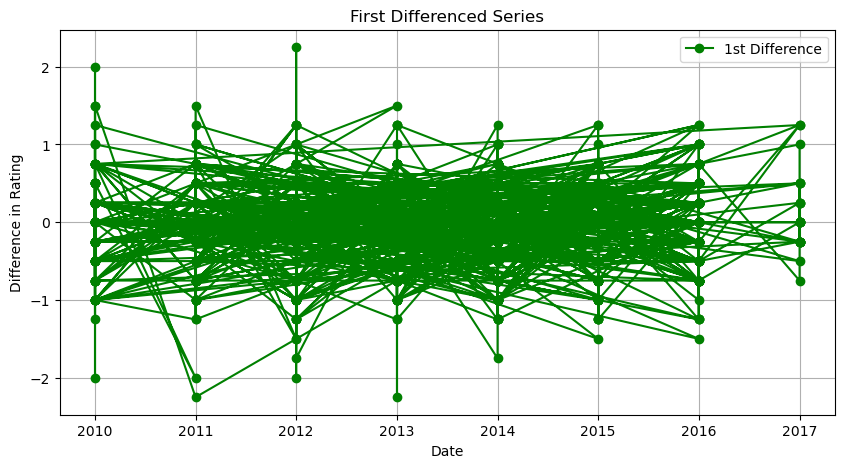

In [66]:
# Step 7:
# If your data isn’t stationary, conduct a round of differencing
df_subset['Diff1'] = df_subset['rating'].diff()
df_diff1 = df_subset['Diff1'].dropna()

# Plot the first differenced series.
plt.figure(figsize=(10, 5))
plt.plot(df_diff1.index, df_diff1.values, marker='o', linestyle='-', color='g', label='1st Difference')
plt.title('First Differenced Series')
plt.xlabel('Date')
plt.ylabel('Difference in Rating')
plt.legend()
plt.grid(True)
plt.show()

In [67]:
# Conduct the Dickey-Fuller test on the first differenced series.
adf_result_diff1 = adfuller(df_diff1)
print("Dickey-Fuller Test on First Differenced Series:")
print("ADF Statistic (1st Diff): {:.4f}".format(adf_result_diff1[0]))
print("p-value (1st Diff): {:.4f}".format(adf_result_diff1[1]))
print("Critical Values:")
for key, value in adf_result_diff1[4].items():
    print("  {}: {:.4f}".format(key, value))

Dickey-Fuller Test on First Differenced Series:
ADF Statistic (1st Diff): -15.7890
p-value (1st Diff): 0.0000
Critical Values:
  1%: -3.4350
  5%: -2.8636
  10%: -2.5679


#### Confirming stationarity
##### Since the ADF statistic is significantly lower than critical values and the p-value is nearly zero, 
##### I’m rejecting the null hypothesis, indicating that the series is stationary.

<Figure size 1000x500 with 0 Axes>

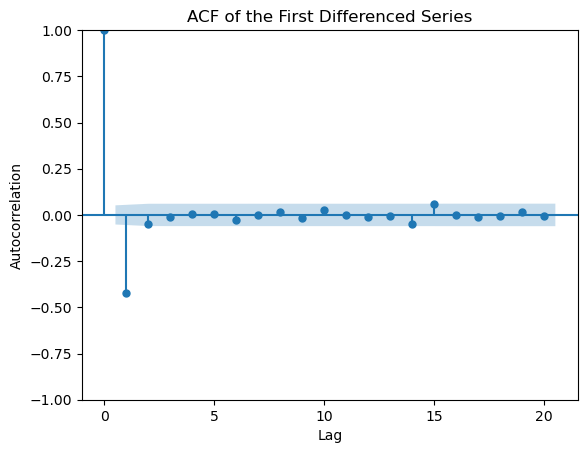

In [58]:
# Step 9: Check your data’s autocorrelations.
plt.figure(figsize=(10, 5))
plot_acf(df_diff1, lags=20)
plt.title('ACF of the First Differenced Series')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()
